# Reinforcement Learning

In [1]:
import numpy as np
from collections import defaultdict


This assignment can be seen as a *capstone project*, in which you can illustrate your knowledge of reinforcement learning techniques.

### Description of the model
We will study for the effects of using reinforcement algorithms in a market that is characterized as a *sequential pricing duopoly*. It is the model of Maskin and Tirole (1988) that will be considered. Below you will find a description of the situation, as in Klein (2021). You may want to read that paper as well! 

There is a competition between two firms $i\in \{1,2\}$ on a market for a who in turns announce their prices. Time is indexed by $t\in\{0,1,2,3,\ldots\}.$ Adjustment in price occur sequentially: in odd numbered periods firm 1 adjusts or confirms its price $p_{1t}\in P$, and in even-numbered periods firm 2 adjusts its price $p_{2t}\in P$, where prices are discrete and equally distributed in the interval $[0,1],$ so that $P=\{0,\tfrac{1}{k},\tfrac{2}{k},\ldots, \tfrac{k-1}{k},1\}$. Assume that there are no marginal or fixed costs so that firm $i$ at time $t$ has profits
  $$\pi_i(p_{it},p_{jt})=p_{it}D_i(p_{it},p_{jt},)$$

  where $D_i(p_{it},p_{jt})$ is the demand for good from firm $i$ given own price $p_{it}$ and competitor's price $p_{jt}$. The demand is a simple function, given by
  $$
  D_i(p_{it},p_{jt})=\left\{\begin{array}{ll}
1-p_{it} & \text{ if }p_{it}<p_{jt}\\
0.5(1-p_{it}) & \text{ if }p_{it}=p_{jt}\\
0 & \text{ if }p_{it}>p_{jt}\\
  \end{array}
\right.
  $$
  

  In particular, if the price is higher than that of the competitor, the demand for $i$'s good is 0. In case the prices are equal, the market for the good is split between the firms.   

### Behavior of the players
  The firms discount future profits with a discount factor $\delta\in [0,1)$, where each firm has as objective to maximize at time $t$ the future stream of payoffs, so 
  $$\max \sum_{s=0}^\infty \delta^s\pi_i(p_{i,t+s},p_{j,t+s}).$$
  We will assume that players use Markovian strategies, those that only use information that is directly payoff-relevant. In this case this will be the previous competitor price $p_{j,t-1}$. So the strategy of firm $i$ is a dynamic reaction function $R_i(\cdot)$, where in its turn $p_{it}=R_i(p_{j,t-1}).$ it is not hard to show that the equilibrium outcomes (optimal reaction functions) are described as follows. A strategy pair, a pair of reaction functions $(R_1,R_2)$, is a Nash equilibrium if for all prices along the equilibrium path the following value-function condition holds for both firms:
  $$V_i(p_{it})=\max_p \left[\pi_i(p,p_{jt})+\mathbb{E}_{p_{j,t+1}}[\delta \pi_{i}(p,p_{j,t+1})+\delta^2 V_i(p_{j,t+1})]\right],$$ where $R_i(p_j)$ is a maximizing choice of firm $i$ and the expectation over competitor response $p_{j,t+1}$ is taken with respect to the distribution of $R_j(p)$.\\
  One Nash-equilibrium is given by the static reaction function in which firms always price at or one increment above marginal cost. One issue here is that agents need to know the full model for these kind of solutions. Below we will assume that the players do not know the market circumstances, i.e., the demand function. Then the firms will have to learn the function by observation of prices and corresponding rewards, the achieved profits. We will choose a sequential version of the $Q$-learning algorithm, therebye avoiding the problems with simultaneous actions. 


## Defining the Q-learning algorithm

Below you find the details about the type of learners.

### Updating the value function
The learning algorithm that firms apply here is an adaptation of the $Q$-learning algorithm. Here the players apply $Q$-learning to update their $Q$-function $Q_i(p_{it},s_t)$, which is the estimated optimal long-run value given current state $s_t\in S$ and choice $p_{it}$. As state we will take the possible prices the opponent can announce, so $S=P$. Then the $Q$-matrix is a $|P|\times |P|$ matrix. After observing own profits, and new state $s_{t+1}$, the algorithm updates entry $Q_i(p_{it},s_t)$ according to the following recursive relationship
\begin{align}
Q_i(p_{it},s_t) & \leftarrow (1-\alpha)\cdot \text{ previous estimate }+ \alpha\cdot\text{ new estimate }\\ 
Q_i(p_{it},s_t) & \leftarrow (1-\alpha) Q_i(p_{it},s_t)+\alpha (\pi_{i}(p_{it},s_{t})+\delta \pi_i(p_{it},s_{t+1})+\delta^2 \max_p Q_i(p,s_{t+1})),\label{eq2}\end{align}
where $\alpha\in (0,1)$ denotes the usual learning rate.

### Action selection
The algorithm adopts a probabilistic action-selection policy, thereby balancing exploration and exploitation. 
With probability $\epsilon_t\in [0,1]$ it selects a price randomly (exploration) and with probability $(1-\epsilon_t)$ it selects the currently perceived optimal price (exploitation), so that 
\begin{equation}\label{eq1}
p_{it}=\left\{\begin{array}{ll}
\sim \text{Unif}(P) & \text{ with probability }\epsilon_t\\
=\arg\max_p Q_i(p,s_{t}). 
\end{array}\right.
\end{equation}

Here $\text{Unif}(P)$ stands for the uniform distribution on the finite discrete set $P$. 

### An example
Suppose you have drawn random prices $p^i_t$ for player $i$ for moment $t=1,2,3,4$, that is, 
$$p^1_1,p^2_2,p^1_3,p^2_4 \in \{0,\tfrac{1}{k},\tfrac{2}{k},\ldots,1\}.$$
Then the next price to be determined is that of player 1, the action-state pair that is re-evaluated is $(p^1_3,p^2_2)$. It is the last decision by player 1, based on the state/information $p^2_2$. So the entry $Q_1(p^1_3,p^2_2)$ is changed using
\begin{align*} Q_1(p^1_3,p^2_2)\leftarrow & (1-\alpha)Q_1(p^1_3,p^2_2)+ \alpha\left(\pi_1(p^1_3,p^2_2)+\delta \pi_1(p^1_3,p^2_4))+\delta^2\max_p Q_1(p,p^2_4)\right).
\end{align*}
Then the next price for player 1 will be 
$$p_5^1\in \arg\max_p Q_1(p,p^2_4).$$
Now we have the new sequence of prices 
$$p^1_1,p^2_2,p^1_3,p^2_4,p_5^1 \in \{0,\tfrac{1}{k},\tfrac{2}{k},\ldots,1\}$$
and it's player 2's turn with updating
\begin{align*} Q_2(p^2_4,p^1_3)\leftarrow & (1-\alpha)Q_2(p^2_4,p^1_3)+\alpha\left(\pi_1(p^2_4,p^1_3)+\delta \pi_1(p^2_4,p^1_5))+\delta^2\max_p Q_2(p,p^1_5)\right).
\end{align*}
Then in addition
$$p_6^2 \in \arg\max_pQ_2(p,p_5^1),$$
andsoforth. 


### Exercise 1
Implement the demand function and profit function below:

In [2]:
# Changed p1 to pi and p2 to pj 
# (Because it makes it less confusing with regards to players)
def demand_func(pi,pj):
    if pi < pj:
        return 1-pi
    elif pi > pj:
        return 0
    else:
        return 0.5*(1-pi)

def profit_func(pi,pj):
    return pi*demand_func(pi,pj)

### Exercise 2
The following parameters are exogenous in the model
* number of episodes
* episode length
* learning rate
* exploration parameter

Initialize those parameters here:

In [3]:
# Initialize your exogeneous parameters here:
episodes = 100000 # Number of episodes
ep_length = ... # Not sure about this and where it fits in !!!!!!!!!
gamma = 0.9 #Discount factor
alpha = 0.1 # Hyperparamater - learning rate
epsilon = 0.1 # For epsilon-greedy


### Exercise 3

See to an appropriate initialization of

* actions 
* Q-tables
* starting player
 

In [7]:
# Initialize actions, Q-tables, starting player/other player:
# Actions
actions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] # List of possible prices
k = len(actions) #Number of possible prices

#Q-tables
Q1 = np.zeros((k, k))
Q2 = np.zeros((k, k))

# Starting player is player 1


### Exercise 4
The core of the assignment is the implementation of the $Q$-learning part. Write a function ``Qlearn`` that carries out the simulation, in which the two players take turns and determine their prices. At each step the $Q$-tables have to be updated in the way described.
A couple of things before you enter your code:

* Think about the output you want the algorithm to deliver. Points of interest are *convergence* and *optimality of the chosen actions*. The output must fit the analysis that you want to carry out. Klein (2021) provides interesting metrics for that.
* Code as clean as possible. Provide information at the different steps, what you do.


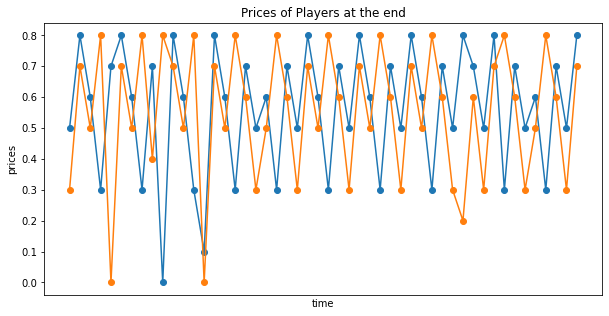

In [9]:
## Define your Q-learn algorithm here

# For plotting onvergence to deterministic asymmetric price cycles
import matplotlib.pyplot as plt

def Qlearn(episodes, gamma, alpha, epsilon, actions, k, Q1, Q2,plot):
    
    # Function for the choice of action because will be reused.
    def action_choice(Q, state, epsilon):
        # Balancing exploration and exploitation with epsilon-greedy
        if np.random.uniform(0, 1) < epsilon:
            return np.random.randint(k) # Random choice
        else:
            return np.argmax(Q[state]) # Greedy choice
    
    # Needed to kick start the learning and playing
    s_new = np.random.randint(k)  # Player 2's initial price
    
    # Store the prices, and profits
    prices_profits = {'price1':[],'price2':[],'profit1':[],'profit2':[]}
    
    # The actual game and algorithm
    for t in range(episodes):
        
        # Player 1 plays
        state = s_new # The state is the price set by the opponent
        action = action_choice(Q1, state, epsilon) # Player makes an action choice
        #print('P1 action is: {}'.format(actions[action]))
        prices_profits['price1'].append(actions[action]) # Append the price1
        
        profit = profit_func(actions[action], actions[state]) # Caclulate the profit for player 1
        s_new = action
        #print('P1 profit is: {}'.format(profit))
        prices_profits['profit1'].append(profit) # Append the profit1

        
        # Player 1 updates their Q function 'Q1'
        Q1[state, action] = (1 - alpha) * Q1[state, action] + alpha * (profit + gamma * np.max(Q1[s_new]))
        
        
        # Player 2 plays
        state = s_new
        action = action_choice(Q2, state, epsilon)
        #print('P2 action is: {}'.format(actions[action]))
        prices_profits['price2'].append(actions[action]) # Append the price2
        
        profit = profit_func(actions[action], actions[state])
        s_new = action
        #print('P2 profit is: {}'.format(profit))
        prices_profits['profit2'].append(profit) # Append the profit2
        
        Q2[state, action] = (1 - alpha) * Q2[state, action] + alpha * (profit + gamma * np.max(Q2[s_new]))
        
    
    if plot:
        # Plot the graphs to show convergence of prices
        fig, ax = plt.subplots(figsize=(10,5))
        ax.plot(prices_profits['price1'][-50:], marker='o')
        ax.plot(prices_profits['price2'][-50:], marker='o')
        ax.set_xlabel('time')
        ax.set_ylabel('prices')
        ax.set_title('Prices of Players at the end')
        ax.set_xticks([]) # Remove the xticks as they serve no purpose
        plt.show()
    
    return prices_profits



prices_profits = Qlearn(episodes, gamma, alpha, epsilon, actions, k, Q1, Q2,plot=True)

### Exercise 5

Report on the findings for different settings:

* Consider the case of $k=4$ versus $k=15$, the number of prices
* During the course you have seen several setups for $(\alpha, \epsilon_t)$, i.e., the learning rate and exploration. Choose a different setup for these. 

Report on your findings -- about convergence and optimality in the markets. This report is at most 2 pages A4 long, exclusive illustrations and visualisations. 


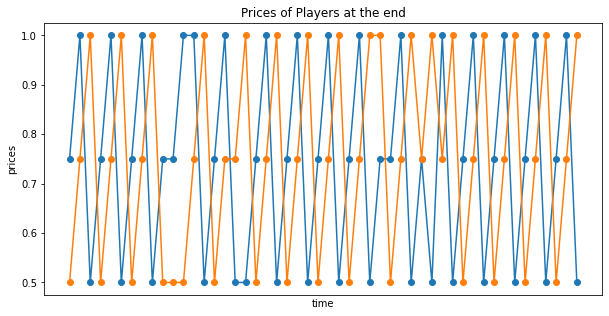

In [42]:
# k = 4 
actions = [0,0.25,0.5,0.75,1]
k = len(actions)
# Restart the Qtables
Q1 = np.zeros((k, k))
Q2 = np.zeros((k, k))
prices_profits = Qlearn(episodes, gamma, alpha, epsilon, actions, k, Q1, Q2, plot=True)

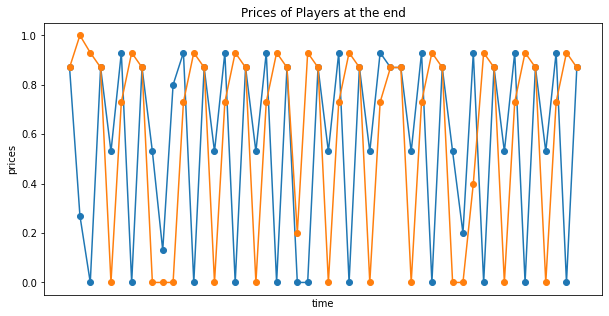

In [43]:
# k = 15 
actions = [0,0.067,0.13,0.2,0.27,0.33,0.4,0.47,0.53,0.6,0.67,0.73,0.8,0.87,0.93,1]
k = len(actions)
# Restart the Qtables
Q1 = np.zeros((k, k))
Q2 = np.zeros((k, k))
prices_profits = Qlearn(episodes, gamma, alpha, epsilon, actions, k, Q1, Q2, plot=True)

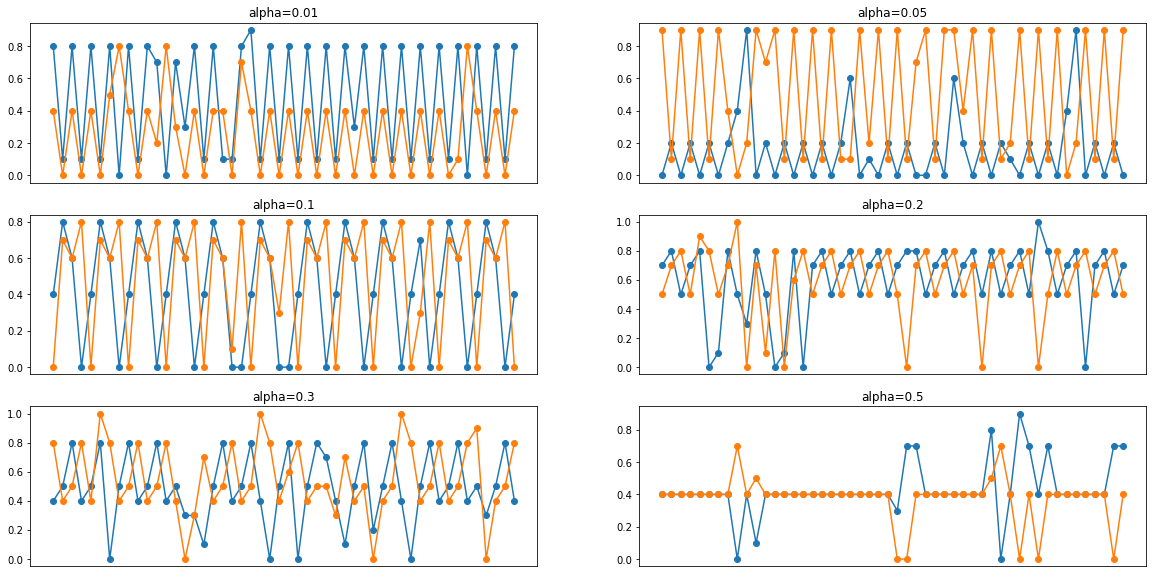

In [68]:
# Different alphas 
alphas = [0.01,0.05,0.1,0.2,0.3,0.5]

episodes = 10000 # Less episodes

# Normal action space
actions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] # List of possible prices
k = len(actions) #Number of possible prices

values =[]
for alpha in alphas:
    
    # Reset Q: 
    Q1 = np.zeros((k, k))
    Q2 = np.zeros((k, k))
    
    prices_profits = Qlearn(episodes, gamma, alpha, epsilon, actions, k, Q1, Q2, plot=False)
    values.append(prices_profits) 

# Plot the different final 50 values 
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,10))

axs[0,0].plot(values[0]['price1'][-50:], marker='o')
axs[0,0].plot(values[0]['price2'][-50:], marker='o')
axs[0,0].set_title('alpha=0.01')
axs[0,0].set_xticks([])
axs[0,1].plot(values[1]['price1'][-50:], marker='o')
axs[0,1].plot(values[1]['price2'][-50:], marker='o')
axs[0,1].set_title('alpha=0.05')
axs[0,1].set_xticks([])

axs[1,0].plot(values[2]['price1'][-50:], marker='o')
axs[1,0].plot(values[2]['price2'][-50:], marker='o')
axs[1,0].set_title('alpha=0.1')
axs[1,0].set_xticks([])
axs[1,1].plot(values[3]['price1'][-50:], marker='o')
axs[1,1].plot(values[3]['price2'][-50:], marker='o')
axs[1,1].set_title('alpha=0.2')
axs[1,1].set_xticks([])

axs[2,0].plot(values[4]['price1'][-50:], marker='o')
axs[2,0].plot(values[4]['price2'][-50:], marker='o')
axs[2,0].set_title('alpha=0.3')
axs[2,0].set_xticks([])
axs[2,1].plot(values[5]['price1'][-50:], marker='o')
axs[2,1].plot(values[5]['price2'][-50:], marker='o')
axs[2,1].set_title('alpha=0.5')
axs[2,1].set_xticks([])
plt.show()

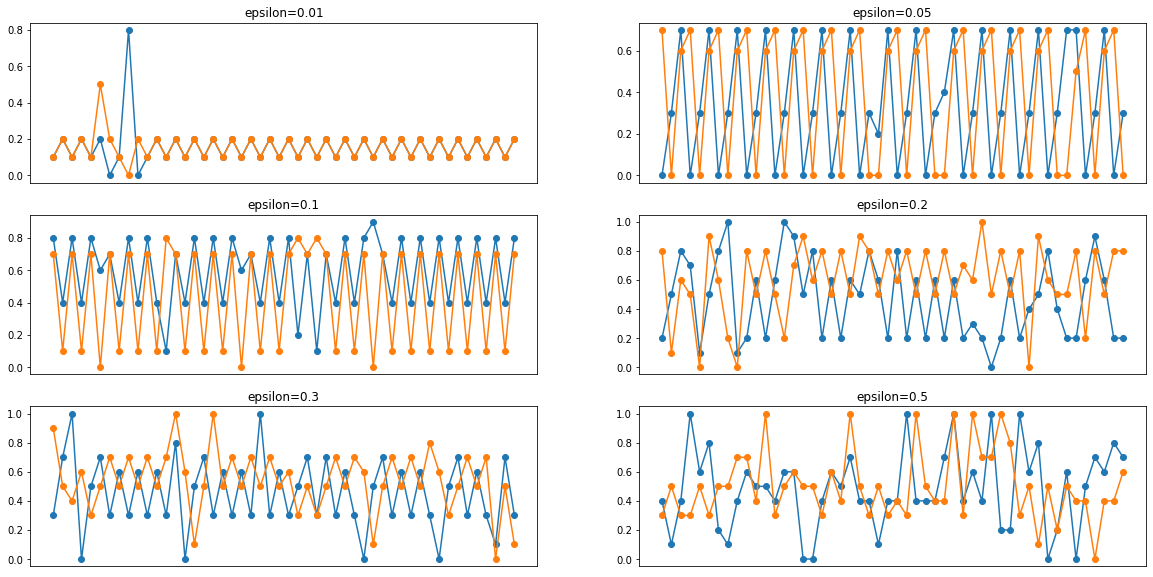

In [69]:
# Different epsilons 
epsilons = [0.01,0.05,0.1,0.2,0.3,0.5]

episodes = 10000 # Less episodes

# Normal action space
actions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] # List of possible prices
k = len(actions) #Number of possible prices
alpha = 0.1

values =[]
for epsilon in epsilons:
    
    # Reset Q: 
    Q1 = np.zeros((k, k))
    Q2 = np.zeros((k, k))
    
    prices_profits = Qlearn(episodes, gamma, alpha, epsilon, actions, k, Q1, Q2, plot=False)
    values.append(prices_profits) 

# Plot the different final 50 values 
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,10))

axs[0,0].plot(values[0]['price1'][-50:], marker='o')
axs[0,0].plot(values[0]['price2'][-50:], marker='o')
axs[0,0].set_title('epsilon=0.01')
axs[0,0].set_xticks([])
axs[0,1].plot(values[1]['price1'][-50:], marker='o')
axs[0,1].plot(values[1]['price2'][-50:], marker='o')
axs[0,1].set_title('epsilon=0.05')
axs[0,1].set_xticks([])

axs[1,0].plot(values[2]['price1'][-50:], marker='o')
axs[1,0].plot(values[2]['price2'][-50:], marker='o')
axs[1,0].set_title('epsilon=0.1')
axs[1,0].set_xticks([])
axs[1,1].plot(values[3]['price1'][-50:], marker='o')
axs[1,1].plot(values[3]['price2'][-50:], marker='o')
axs[1,1].set_title('epsilon=0.2')
axs[1,1].set_xticks([])

axs[2,0].plot(values[4]['price1'][-50:], marker='o')
axs[2,0].plot(values[4]['price2'][-50:], marker='o')
axs[2,0].set_title('epsilon=0.3')
axs[2,0].set_xticks([])
axs[2,1].plot(values[5]['price1'][-50:], marker='o')
axs[2,1].plot(values[5]['price2'][-50:], marker='o')
axs[2,1].set_title('epsilon=0.5')
axs[2,1].set_xticks([])
plt.show()